## Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, precision_score, recall_score, roc_auc_score

## Import Data

In [2]:
test=pd.read_csv("data/test.csv")
train=pd.read_csv("data/train.csv")

In [3]:
train[['timestamp','value','predicted','is_anomaly']].head()

,timestamp,value,predicted,is_anomaly
0,1425008573,42,44.072500,False
1,1425008873,41,50.709390,False
2,1425009173,41,81.405120,False
3,1425009473,61,39.950367,False
4,1425009773,44,35.350160,False


In [4]:
train.shape

(15830, 4)

In [5]:
temp_disp = train['is_anomaly'].value_counts().reset_index()
temp_disp.columns = ['label','count']
temp_disp['percent'] = train['is_anomaly'].value_counts(1)*100
temp_disp

,label,count,percent
0,False,15054,95.097915
1,True,776,4.902085


In [6]:
dict_label = {False:0, True:1}

def func(x):
    return dict_label[x]

train["is_anomaly_label"] = train["is_anomaly"].apply(func)

train["abs_diff"] = train["value"] - train["predicted"]
train['abs_diff'] = train['abs_diff'].abs()

<AxesSubplot:>

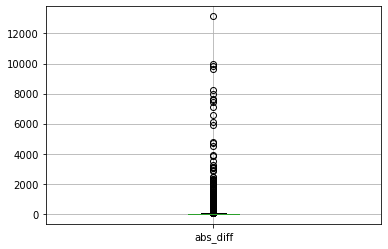

In [7]:
train.boxplot(column=['abs_diff']) 

In [8]:
# Q1 = train.quantile(0.25)
# Q3 = train.quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [9]:
# ## remove outlier

# cols = ['abs_diff'] # one or more

# Q1 = train[cols].quantile(0.25)
# Q3 = train[cols].quantile(0.75)
# IQR = Q3 - Q1

# train_outlier_rem = train[~((train[cols] < (Q1 - 1.5 * IQR)) |(train[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [10]:
# print(f'''%age of data removed after removing outliers :{round((train.shape[0]-train_outlier_rem.shape[0])/train.shape[0]*100,2)}, out of {train.shape[0]} rows''')
# print(f"Total data left : {train_outlier_rem.shape[0]} rows")

In [11]:
# train_outlier_rem.boxplot(column=['abs_diff']) 

In [12]:
# train_outlier_rem.describe()

<AxesSubplot:>

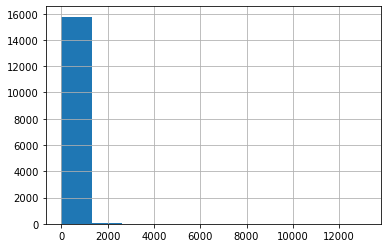

In [13]:
train["abs_diff"].hist()

In [14]:
X_train = train[["value","predicted"]].values #,
Y_train = train["is_anomaly_label"].values

X_train= StandardScaler().fit_transform(X_train)

x_train,x_test,y_train, y_test=train_test_split(X_train,Y_train,test_size=0.2, random_state=1)

In [15]:
x_train[:2]

array([[ 0.54833685,  1.32187979],
       [-0.05150634,  0.07628727]])

In [16]:
x_train.shape ,x_test.shape ,y_train.shape , y_test.shape

((12664, 2), (3166, 2), (12664,), (3166,))

In [17]:
np.where(y_train == 0)

(array([    0,     1,     2, ..., 12660, 12661, 12663]),)

In [18]:
legend_label = {0:False, 1:True}

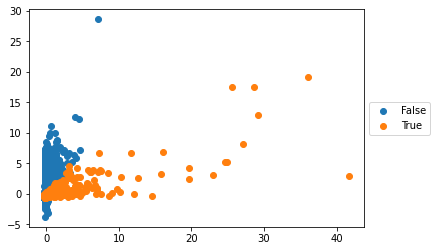

In [19]:
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], label=legend_label[class_value])
# show the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## XgBoost Model

In [20]:
# %%time

# clf = XGBClassifier(objective= 'binary:logistic')
# # set up our search grid
# param_grid = {"max_depth":    [3, 4, 5],
#               "n_estimators": [200, 500, 800, 1100, 1400],
#               "learning_rate": [0.01, 0.015, 0.001]}

# # try out every combination of the above values
# search = GridSearchCV(clf, param_grid, cv=5).fit(x_train, y_train)
# print("The best hyperparameters are ",search.best_params_)

In [21]:
clf_xgb = XGBClassifier(learning_rate = 0.015,
                           n_estimators  = 500,
                           max_depth     = 5,
                        objective= 'binary:logistic', probability=True,eta = 0.7)
clf_xgb.fit(x_train, y_train)
pred=clf_xgb.predict(x_test)

[22:12:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "probability" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [22]:
xg_f1 = f1_score(y_test, pred, average='weighted')
xg_acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted'), 
recall = recall_score(y_test, pred, average='weighted')


xg_f1, xg_acc, precision, recall

(0.9736334100825981,
 0.9753632343651295,
 (0.973300811484651,),
 0.9753632343651295)

In [23]:
confusion_matrix(y_test, pred)

array([[3004,   21],
       [  57,   84]])

In [24]:
xg_pred_prob = clf_xgb.predict_proba(x_test)[:, 1]

roc_auc_score(y_test, xg_pred_prob)

0.9676267510696911

## Test data

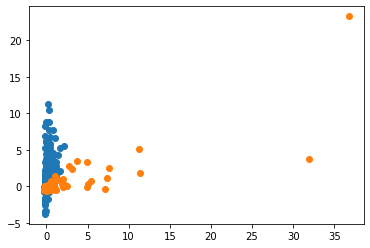

In [25]:
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_test == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1])
# show the plot
plt.show()

## Predicted Data

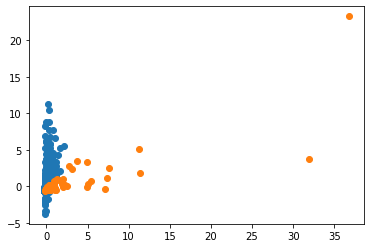

In [26]:
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(pred == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1])
# show the plot
plt.show()

## Train Decision boundary

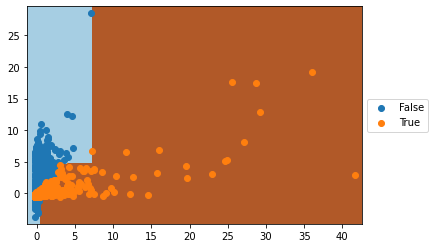

In [27]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_xgb.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], cmap='Paired', label=legend_label[class_value])
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## decision boundary on test data

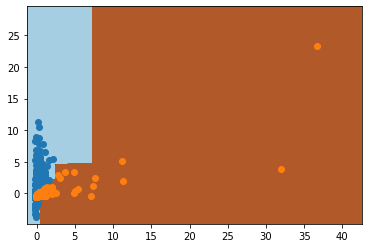

In [28]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_xgb.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(pred == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], cmap='Paired')

## SVM model

In [29]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf_svm.fit(x_train,y_train)

pred_svm=clf_svm.predict(x_test)


svm_f1 = f1_score(y_test, pred_svm, average='weighted')
svm_acc = accuracy_score(y_test, pred_svm)
confusion_matrix(y_test, pred_svm)

array([[3024,    1],
       [  88,   53]])

In [30]:
svm_f1, svm_acc, precision_score(y_test, pred_svm, average='weighted'), recall_score(y_test, pred_svm, average='weighted')

(0.965817119247072, 0.9718888186986734, 0.9721569940399666, 0.9718888186986734)

In [31]:
xg_pred_svm = clf_svm.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, xg_pred_svm)

0.9144340894437607

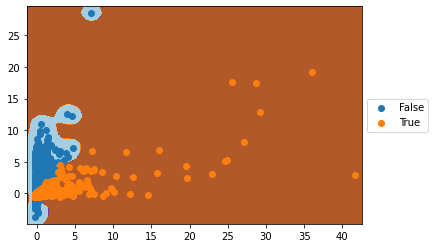

In [32]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_svm.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], cmap='Paired',label=legend_label[class_value])
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

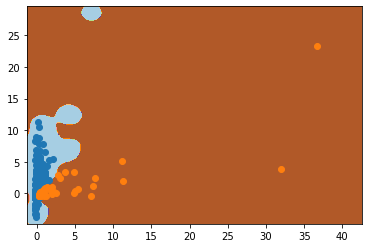

In [33]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_svm.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')



for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(pred_svm == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], cmap='Paired')

## Multi layer perceptron

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
clf_nn = MLPClassifier(random_state=1, max_iter=300)
clf_nn.fit(x_train,y_train)

pred_nn=clf_nn.predict(x_test)


nn_f1 = f1_score(y_test, pred_nn, average='weighted')
nn_acc = accuracy_score(y_test, pred_nn)
confusion_matrix(y_test, pred_nn)

array([[3006,   19],
       [  61,   80]])

In [36]:
nn_f1, nn_acc, precision_score(y_test, pred_nn, average='weighted'), recall_score(y_test, pred_nn, average='weighted')

(0.9726076347137117,
 0.9747315224257739,
 0.9724493802665014,
 0.9747315224257739)

In [37]:
pred_nn_prob = clf_nn.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, pred_nn_prob)

0.9158150167047651

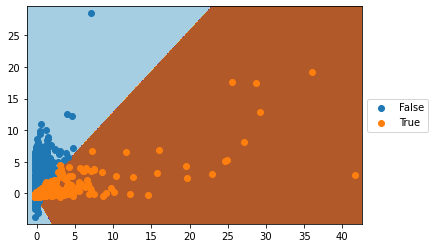

In [38]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_nn.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], cmap='Paired',label=legend_label[class_value])
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

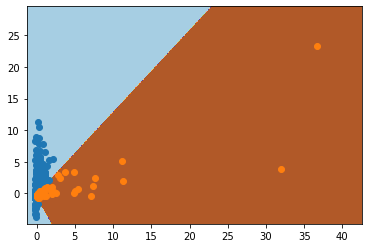

In [39]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_nn.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(pred_nn == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], cmap='Paired')

## K Nearest Neighbor Model

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate model
clf_knn = KNeighborsClassifier(n_neighbors=3)
# fit model
clf_knn.fit(x_train, y_train)

pred_knn=clf_knn.predict(x_test)


knn_f1 = f1_score(y_test, pred_knn, average='weighted')
knn_acc = accuracy_score(y_test, pred_knn)
confusion_matrix(y_test, pred_knn)

array([[2987,   38],
       [  50,   91]])

In [41]:
knn_f1, knn_acc, precision_score(y_test, pred_knn, average='weighted'), recall_score(y_test, pred_knn, average='weighted')

(0.9716145118166303, 0.9722046746683513, 0.971150562117495, 0.9722046746683513)

In [42]:
prob_pred_knn = clf_knn.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, prob_pred_knn)

0.8695703651603071

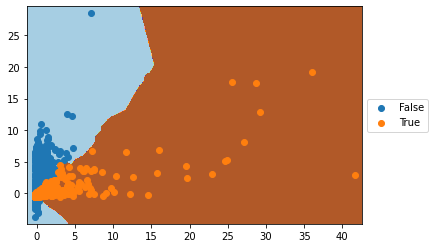

In [43]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_knn.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_train == class_value)
    # create scatter of these samples
    plt.scatter(x_train[row_ix, 0], x_train[row_ix, 1], cmap='Paired',label=legend_label[class_value])
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

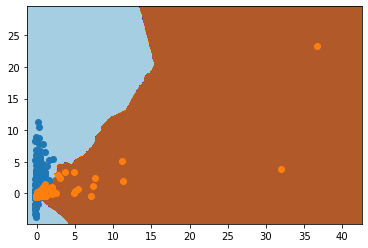

In [44]:
# define bounds of the domain
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

# make predictions for the grid
yhat = clf_knn.predict(grid)

# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
plt.contourf(xx, yy, zz, cmap='Paired')


# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(pred_knn == class_value)
    # create scatter of these samples
    plt.scatter(x_test[row_ix, 0], x_test[row_ix, 1], cmap='Paired')